[more details here](https://www.kaggle.com/code/shunsukeozeki/dogs-basic-dcgan-tutorial-with-pytorch)

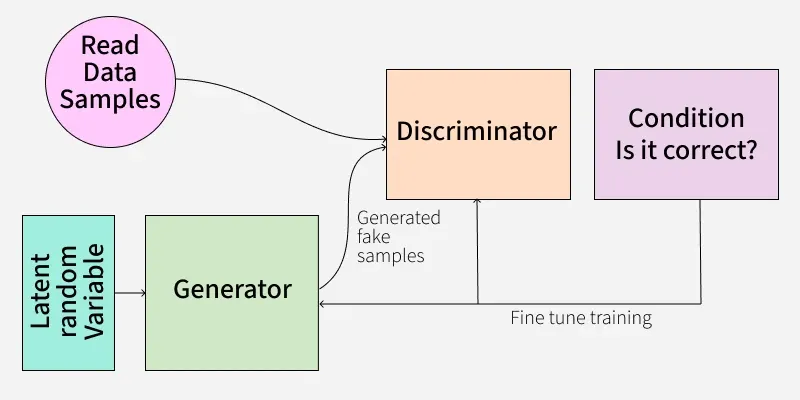<br>
[credit](https://www.geeksforgeeks.org/deep-learning/generative-adversarial-network-gan/)

# GAN Example PyTorch

A **G**enerative **A**dversarial **N**etwork (GAN) consists of two competing neural networks:<br>
a generator that generates images from a vector with randomly generated numbers (= *latent vector*) via up-sampling and a<br> 
discriminator that is a classification CNN that has to distinguish between the fake images created by the generator and a training set of real images.<br> The generator tries to maximize the loss of the discriminator and therefore learns how to generate realistic images. In this example we want to explore a basic set-up that is supposed to learn how to generate images of cat and/or dogs.  

<br>

## 1) Loading Libraries

First, we load our standard libaries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Next, we import relevant **PyTorch** libraries since **PyTorch** is a lot faster than **Keras/TF**:

In [ ]:
import torch
import torch.nn as nn         # neural nets for basic building blocks (dense layer = linear, convolution layers etc) 
import torchvision            # torch vision for tools handeling the dataset (loading, augmentation, splitting training data etc)
import torch.optim as optim   # optimizer, such as adam
from torchvision import transforms # transforming datasets into "tensors" and thereby scale and normalize the images

Ideally, we want to run our model on a graphics device. For that purpose we define a function that checks if **cuda** is available and if we can run the model on our GPU: 

In [ ]:
def test_cuda():
    print("PyTorch version: ", torch.__version__)
    print("CUDA version: ", torch.version.cuda)
    print("CUDA Available: ", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("Number of GPUs: ", torch.cuda.device_count())
        print("GPU Name: ", torch.cuda.get_device_name(0))

In [ ]:
test_cuda()

In case **cuda** is available and a suitable GPU was found, we will allocate the model to our GPU device using *to_device*. Therefore, we define the device (either GPU or CPU)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(device)

<br>

## 2) Loading Data

The dataset has to be located in a folder either locally or online. Therefore, one needs to set the variable *root* in *torchvision.datasets.ImageFolder* with the path name. This function will transform the images into "tensors", a PyTorch internal format which is similar to *numpy* arrays, and we can thereby scale and normalize the images. 

In [ ]:
image_size = 32
dataset    = torchvision.datasets.ImageFolder(root      = r"C:\Users\MMH_user\Desktop\QBM\QBM\courses\Python\ANN\pet pics", 
                                              transform = transforms.Compose([transforms.Resize((image_size, image_size)),
                                                                              transforms.CenterCrop(image_size),
                                                                              transforms.ToTensor(),
                                                                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])) 
                                                                              # first tuple: mean values for each RGB color channel, 
                                                                              # 2nd tuple: std values for each RGB color channel

Loading the data:

In [ ]:
batch_size = 16
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True)

Let us check the image shapes and display one image:

In [ ]:
I = dataloader.dataset[100][0] # image 100 
print(I.shape)

In [ ]:
plt.imshow(np.transpose(I, (1, 2, 0)))

We also want to check how many images are in the training dataset:

In [ ]:
print(str(len(dataset.imgs)) + ' images')

<br>

## 3) Generator and Discriminator

Now, we define the discriminator and the generator for our GAN. Let's start with the discriminator:<br>

3.1) The discriminator is essentially a sequential **classification convolution network**, that has to solve a binary classification problem (real or fake images). Therefore, we add a sigmoid layer at the end of the network. Note, that the discriminator can have many different configurations and this is just one example.

In [ ]:
class Discriminator(nn.Module):
    
    def __init__(self, Nchan):
        super().__init__()

        self.model = nn.Sequential(
        nn.Conv2d(in_channels = Nchan, out_channels = 32, kernel_size = 3, stride = 2, padding = 1),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.25),
        nn.Conv2d(32, 64, kernel_size = 3, stride = 2, padding = 1),
        nn.ZeroPad2d((0, 1, 0, 1)),
        nn.BatchNorm2d(64, momentum = 0.82), # batches are normalized (mean, variance), but we want to do this consitently over many batches
                                             # and therefore "remember" the mean, variance of the previous batches using a momentum term 
                                             # (see momentum for SGD) 
        nn.LeakyReLU(0.25),
        nn.Dropout(0.25),
        nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding = 1),
        nn.BatchNorm2d(128, momentum = 0.82),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.25),
        nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(256, momentum = 0.8),
        nn.LeakyReLU(0.25),
        nn.Dropout(0.25),
        nn.AdaptiveAvgPool2d((1, 1)), 
        nn.Flatten(),
        nn.Linear(256, 1),
        nn.Sigmoid()  # binary class problem (fake images vs real images), softmax would also work
        )

    def forward(self, img):
        validity = self.model(img)
        return validity

3.2) The generator **just up-samples a vector to an image**. This vector (aka *latent vector*) contains randomly generated numbers which will be created in each iteration. The structure of the generator is pretty much that of the **decoder part of a segmentation CNN**. The generator doesn't have to have the same structure of the discriminator. 

In [ ]:
class Generator(nn.Module):
    
    def __init__(self, latent_dim):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, momentum=0.78),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=0.78),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img

<br>

## 4) Running the model

Before we can run the model, we set the parameters such as learning rate and the size of the latent vector:

In [ ]:
latent_dim = 100     # length of latent vector
lr         = 0.0001  # learing rate
beta1      = 0.8     # momentum, often denoted as beta1
beta2      = 0.999   # beta for rms prop
num_epochs = 60

Now we initialize both, the discriminator and the generator and thereby assign them to the current device (GPU or CPU):

In [ ]:
Nchan = I.shape[0]

In [ ]:
generator     = Generator(latent_dim).to(device)
discriminator = Discriminator(Nchan).to(device)

We also need to define the loss (binary cross entropy, BCE) and the optimizer:

In [ ]:
adversarial_loss = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(),     lr = lr, betas = (beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr = lr, betas = (beta1, beta2))

Finally, we run the model over the different epochs and the number of iterations defined by the batchsize

In [ ]:
for epoch in range(num_epochs):
    for i, batch in enumerate(dataloader):
       
        real_images = batch[0].to(device) 

        # target vector for loss calculation (binary cross entropy, BCE)
        y_valid     = torch.ones(real_images.size(0), 1, device=device)
        y_fake      = torch.zeros(real_images.size(0), 1, device=device)
       
        real_images = real_images.to(device)

        # the optimizer.zero_grad() method needs to be called before each new optimization step
        # so that the gradients from previous steps would not accumulate
        optimizer_D.zero_grad()
        optimizer_G.zero_grad()
       
        z = torch.randn(real_images.size(0), latent_dim, device = device)
      
        fake_images = generator(z)

        real_loss = adversarial_loss(discriminator(real_images), y_valid)
        fake_loss = adversarial_loss(discriminator(fake_images.detach()), y_fake)
        d_loss    = (real_loss + fake_loss) / 2
    
        d_loss.backward()
        optimizer_D.step()
    
        gen_images = generator(z)

        # the generator has the smallest loss, if the discriminator can't distinguish between fake and real images 
        g_loss     = adversarial_loss(discriminator(gen_images), y_valid)
        
        g_loss.backward()
        optimizer_G.step()
       
        if not i % 100:
            print(f"Epoch [{epoch+1}/{num_epochs}]\
                    Batch {i+1}/{len(dataloader)} "
                f"Discriminator Loss: {d_loss.item():.4f} "
                f"Generator Loss: {g_loss.item():.4f}")

# plotting a few images
    if not epoch % 5:
        with torch.no_grad():
            z = torch.randn(16, latent_dim, device=device)
            generated = generator(z).detach().cpu()
            grid = torchvision.utils.make_grid(generated, nrow = 4, normalize = True)
            plt.imshow(np.transpose(grid, (1, 2, 0)))
            plt.axis("off")
            plt.title('after ' + str(epoch) + ' epoch(s)')
            plt.show()

The result is not perfect, but it definitively goes in the right direction: 

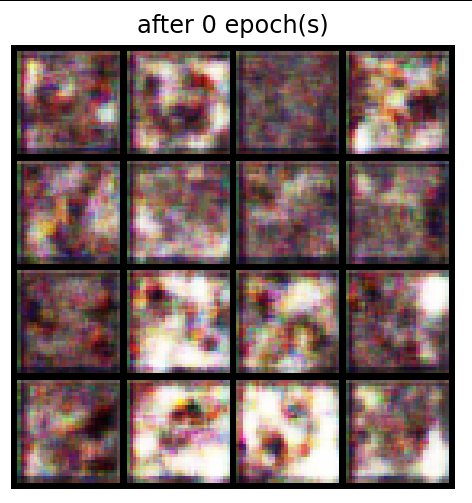
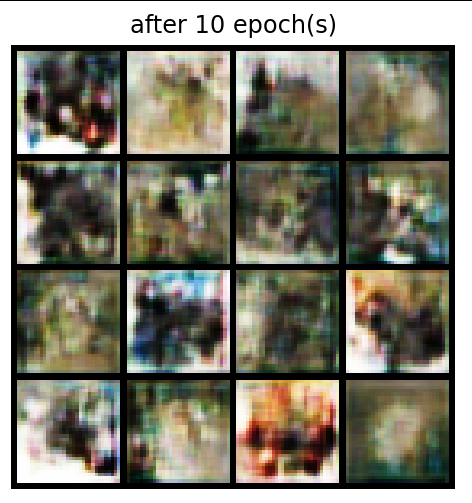
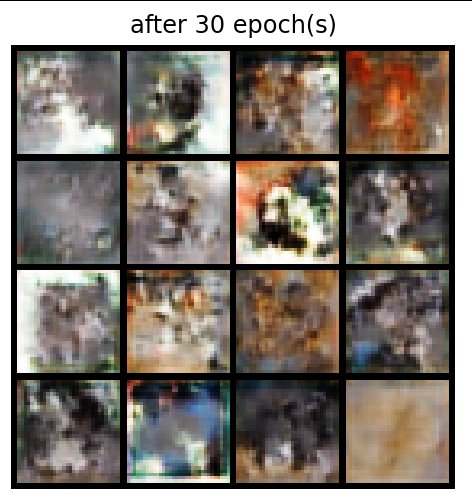
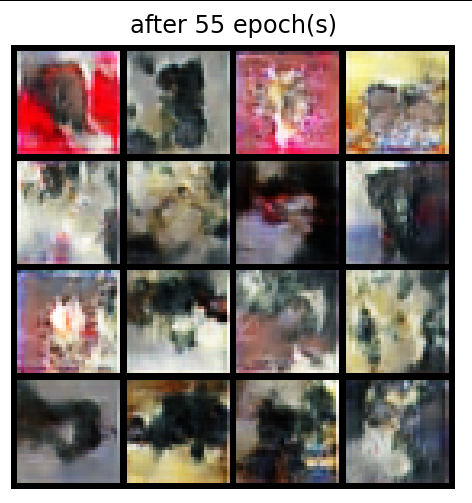